In [1]:
# Autoreload possibly interferes with IntelliJ debugging
# %reload_ext autoreload
# %autoreload 2
import logging
from datetime import datetime
# class FlushHandler(logging.StreamHandler):
#     def emit(self, record):e
#         super().emit(record)
#         self.flush()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# log = lambda msg: logging.info(msg)
log = lambda msg: print(f"{datetime.today()} {msg}")


In [2]:
#assert False
global_force = False

# Full night pipeline (multiple files)

In [3]:
import pandas as pd
import os

input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")

# Find Brainflow files that haven't been copied over

In [4]:
import pytz
from tqdm import tqdm
import paramiko
import re
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()

# Define the time window
time_window = timedelta(minutes=10)

# Define the remote server details
hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/dev/Brainwave-Data'
local_dir = input_dir

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

# List files in the remote directory
stdin, stdout, stderr = ssh.exec_command(f'ls {remote_dir}')
remote_brainflow_files = [f for f in stdout.read().decode().splitlines() if f.endswith(".brainflow.csv")]


2024-12-21 08:20:01,092 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2024-12-21 08:20:01,334 - INFO - Authentication (publickey) failed.
2024-12-21 08:20:01,441 - INFO - Authentication (password) successful!


In [5]:
remote_brainflow_files

['2024-09-30-21-27-49.brainflow.csv',
 '2024-10-01-21-36-11.brainflow.csv',
 '2024-10-02-21-21-15.brainflow.csv',
 '2024-10-04-21-13-39.brainflow.csv',
 '2024-10-05-21-09-47.brainflow.csv',
 '2024-10-06-21-29-18.brainflow.csv',
 '2024-10-07-21-35-18.brainflow.csv',
 '2024-10-08-21-21-34.brainflow.csv',
 '2024-10-09-21-22-04.brainflow.csv',
 '2024-10-11-21-16-27.brainflow.csv',
 '2024-10-15-22-01-52.brainflow.csv',
 '2024-10-21-21-30-19.brainflow.csv',
 '2024-10-23-21-24-03.brainflow.csv',
 '2024-10-24-21-35-33.brainflow.csv',
 '2024-10-29-20-42-12.brainflow.csv',
 '2024-10-30-21-26-55.brainflow.csv',
 '2024-11-01-21-32-22.brainflow.csv',
 '2024-11-02-21-29-03.brainflow.csv',
 '2024-11-04-21-20-51.brainflow.csv',
 '2024-11-05-21-34-15.brainflow.csv',
 '2024-11-07-21-26-18.brainflow.csv',
 '2024-11-08-21-16-53.brainflow.csv',
 '2024-11-09-21-27-51.brainflow.csv',
 '2024-11-12-21-11-43.brainflow.csv',
 '2024-11-16-21-54-46.brainflow.csv',
 '2024-11-19-21-29-04.brainflow.csv',
 '2024-11-20

In [6]:
files_to_copy = remote_brainflow_files.copy()

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if ".brainflow.csv.bz2" in full_input_filename:
            file_name_without_bz2 = file_name.removesuffix(".bz2")
            already_have = file_name_without_bz2 in remote_brainflow_files
            print(f"Already have {full_input_filename}: {already_have}")
            if already_have:
                files_to_copy.remove(file_name_without_bz2)



Already have C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-24-18-57-03\2024-07-24-18-57-03.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-04-21-44-08\2024-09-04-21-44-08.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-08-21-01-39\2024-09-08-21-01-39.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-10-21-22-21\2024-09-10-21-22-21.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-11-

In [7]:
files_to_copy

['2024-12-20-21-31-19.brainflow.csv']

In [8]:
import os
import bz2
from tqdm import tqdm

sftp = ssh.open_sftp()
for file in files_to_copy:
    remote_file_path = remote_dir + "/" + file
    local_file_path = os.path.join(input_dir, file)
    log(f"Copying Brainflow backup remote:{remote_file_path} to {local_file_path}")

    # Get the file size
    remote_file_size = sftp.stat(remote_file_path).st_size

    with tqdm(total=remote_file_size, unit='B', unit_scale=True, desc=file, ascii=True) as pbar:
        local_file_path = os.path.join(input_dir, file)
    
        def callback(transferred_so_far, total_to_transfer):
            pbar.update(transferred_so_far - pbar.n)
    
        # Create a file-like object that writes to the local file
        with open(local_file_path, 'wb') as local_file:
            sftp.getfo(remote_file_path, local_file, callback=callback)
sftp.close()

2024-12-21 08:20:02,519 - INFO - [chan 1] Opened sftp connection (server version 3)


2024-12-21 08:20:02.521134 Copying Brainflow backup remote:/home/graham/dev/Brainwave-Data/2024-12-20-21-31-19.brainflow.csv to C:\dev\play\brainwave-data\2024-12-20-21-31-19.brainflow.csv


2024-12-20-21-31-19.brainflow.csv: 100%|##########| 1.93G/1.93G [00:31<00:00, 61.5MB/s]
2024-12-21 08:20:33,962 - INFO - [chan 1] sftp session closed.


In [9]:
ssh.close()


## Convert Brainflow files to FIF

In [10]:
def get_brainflow_compressed_filename(full_input_filename: str) -> str:
    full_output_dirname = webserver.output_dirname(full_input_filename)
    compressed_full_output_filename = str(os.path.join(full_output_dirname, os.path.basename(full_input_filename))) + '.bz2'
    return compressed_full_output_filename

In [ ]:
from datetime import datetime

import webserver
import convert
# import zstandard as zstd
import os
import bz2
import time
import shutil

errors = []
processed = []

# Could get these working later
skip_list = ['2024-09-10-21-22-21']

def compress_bz2(input_file, output_file):
    start_time = time.time()
    with open(input_file, 'rb') as f_in:
        with bz2.open(output_file, 'wb', compresslevel=9) as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_time = time.time()
    return end_time - start_time, os.path.getsize(output_file)

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        try:
            if full_input_filename.endswith(".brainflow.csv"):
                full_output_dirname = webserver.output_dirname(full_input_filename)
                full_output_filename = str(os.path.join(full_output_dirname, 'raw.fif'))
                
                compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
                if not os.path.exists(compressed_full_output_filename):
                    log(f"Compressing file {full_input_filename} to " + compressed_full_output_filename)
                    processed.append("Compressing " + full_input_filename)
                    try:
                        os.mkdir(os.path.dirname(compressed_full_output_filename))
                    except:
                        pass
                    compress_bz2(full_input_filename, compressed_full_output_filename) 
                    
                if os.path.exists(full_output_filename):
                    log(f"Skipping file {full_input_filename} as {full_output_filename} and {compressed_full_output_filename} already exist")
                    continue
                should_skip = False
                for s in skip_list:
                    if s in full_input_filename:
                        log(f"Skipping file {full_input_filename}")
                        should_skip = True
                if not should_skip:
                    log(f"Processing file {full_input_filename}")
                    processed.append("Processing " + full_input_filename)
                    channels = None
                    date_time_str = os.path.basename(full_input_filename).removesuffix(".brainflow.csv")
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')
                    if (date_time_obj > datetime(2024, 9, 1, 0, 0, 0)):
                        channels = ['Fpz-M1']
        
                    if channels is not None:
                        log(f"Processing file {full_input_filename} with channels {channels}")
                        # Changing to gap-filling on 30th Nov
                        convert.convert_and_save_brainflow_file_with_gap_filling(log, full_input_filename, full_output_filename, channels)

        except Exception as e:
            msg = "Error processing file: " + full_input_filename
            log(msg)
            log(e)
            errors.append(msg)


2024-12-21 08:20:49.696738 Skipping file C:\dev\play\brainwave-data\2024-10-02-21-20-34.brainflow.csv as C:\dev\play\brainwave-data\2024-10-02-21-20-34\raw.fif and C:\dev\play\brainwave-data\2024-10-02-21-20-34\2024-10-02-21-20-34.brainflow.csv.bz2 already exist
2024-12-21 08:20:49.697750 Skipping file C:\dev\play\brainwave-data\2024-10-06-21-29-18.brainflow.csv as C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.fif and C:\dev\play\brainwave-data\2024-10-06-21-29-18\2024-10-06-21-29-18.brainflow.csv.bz2 already exist
2024-12-21 08:20:49.697750 Skipping file C:\dev\play\brainwave-data\2024-10-08-21-21-34.brainflow.csv as C:\dev\play\brainwave-data\2024-10-08-21-21-34\raw.fif and C:\dev\play\brainwave-data\2024-10-08-21-21-34\2024-10-08-21-21-34.brainflow.csv.bz2 already exist
2024-12-21 08:20:49.698725 Skipping file C:\dev\play\brainwave-data\2024-10-09-21-22-04.brainflow.csv as C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.fif and C:\dev\play\brainwave-data\2024-10-09-21-22-04\

In [14]:
errors

[]

In [15]:
processed

[]

## Run YASA pipeline on FIF files

In [16]:
import pandas as pd
import run_feature_pipeline
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

errors = []
dataframes = []

# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11', '2024-09-19-21-29-42']
import io
import sys
import contextlib
import traceback
from importlib import reload

reload(run_feature_pipeline)

def process_file(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        try:
            input_file = os.path.join(root, dir_name, "raw.fif")
            if dir_name in skip_list:
                log(f"Skipping {dir_name}: {input_file}")
                return None, False, output_buffer.getvalue(), "Skipped"

            log(f"Processing file: {input_file}")
            if os.path.exists(input_file):
                yasa_df, cached = run_feature_pipeline.cached_pipeline(log, input_file, force or global_force)
                return yasa_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_file}")
                return None, False, output_buffer.getvalue(), "File not found"

        except Exception as e:
            msg = f"Error processing file: {input_file} - {e}"
            log(msg)
            errors.append(msg)
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# yasa_df, cached, stdout, success_or_msg = process_file("C:\\dev\\play\\brainwave-data", "2024-07-16-23-14-52", False)
# stdout, success_or_msg

YASA pipeline:   0%|          | 0/112 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2024-12-20 16:44:52.354252 Processing file: C:...,File not found
1,09-07-2024--22-52-25,False,2024-12-20 16:44:52.355259 Processing file: C:...,File not found
2,2024-07-08-22-51-16,True,2024-12-20 16:44:52.358276 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2024-12-20 16:44:52.365858 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2024-12-20 16:44:52.374268 Processing file: C:...,True
...,...,...,...,...
107,2024-12-17-21-24-11,True,2024-12-20 16:44:54.212106 Processing file: C:...,True
108,2024-12-18-21-32-18,True,2024-12-20 16:44:54.217814 Processing file: C:...,True
109,2024-12-19-21-18-48,True,2024-12-20 16:44:54.222955 Processing file: C:...,True
110,compressed_files,False,2024-12-20 16:44:54.229146 Processing file: C:...,File not found


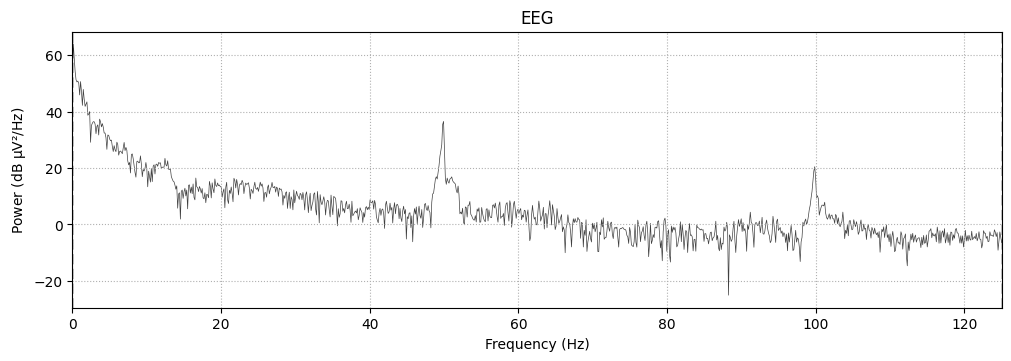

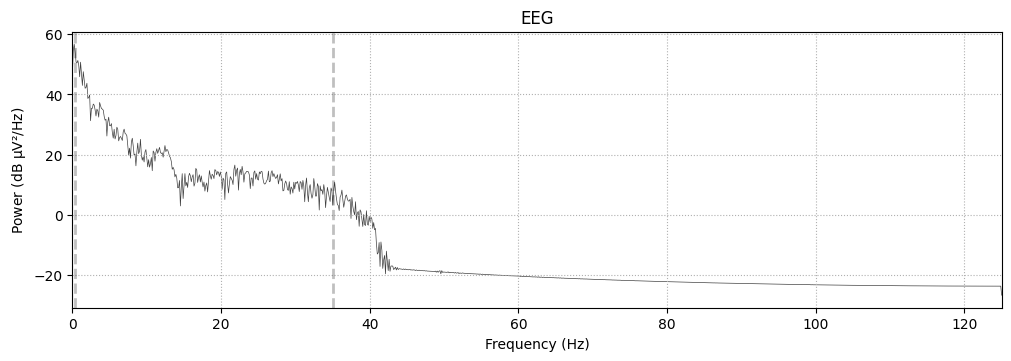

In [17]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="YASA pipeline")):
    yasa_df, cached, stdout, success_or_msg = process_file(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

# Physiological pipeline

In [18]:
import traceback
import os

from importlib import reload
import run_physical_features_pipeline
reload(run_physical_features_pipeline)
import io
import contextlib
from datetime import datetime, timedelta


def process_file_for_physical(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
        try:
            if os.path.exists(input_csv_file):
                yasa_df = pd.read_csv(input_csv_file)
                physical_features_df, cached = run_physical_features_pipeline.cached_physical_features_pipeline(log, input_fif_file, yasa_df, force or global_force)
                return physical_features_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_fif_file} or {input_csv_file}")
                return None, False, output_buffer.getvalue(), "File not found"
        except Exception as e:
            return None, False, output_buffer.getvalue(), (str(e) + " " + traceback.format_exc())

# Testing
# physical_features_df, cached, stdout, success_or_msg = process_file_for_physical("C:\\dev\\play\\brainwave-data", "2024-12-11-21-31-37", False)
# display(stdout)
# display(success_or_msg)
# display(physical_features_df)

'2024-12-20 16:44:54.672041 Loading cached file C:\\dev\\play\\brainwave-data\\2024-12-11-21-31-37\\raw.physical_features.csv\n'

True

,Stage,Confidence,Timestamp,Source,Fpz-M1_Stage,Fpz-M1_Confidence,StageInt,TimestampUK,HR,HrvRMSSDSomewhatRecent,Temp,PositionMinX,PositionMaxX,PositionMedX,PositionMinY,PositionMaxY,PositionMedY,PositionMinZ,PositionMaxZ,PositionMedZ
Epoch,,,,,,,,,,,,,,,,,,,,
0,W,0.994664,2024-12-11 21:31:37.562510967+00:00,Fpz-M1,W,0.994664,0,2024-12-11 21:31:37.562510967+00:00,82.0,31.0,37.07,-769.0,-639.0,-681.5,-94.0,-75.0,-84.5,588.0,656.0,630.5
1,W,0.999240,2024-12-11 21:32:07.562510967+00:00,Fpz-M1,W,0.999240,0,2024-12-11 21:32:07.562510967+00:00,74.0,31.0,37.07,-649.0,-642.0,-646.0,-99.0,-89.0,-92.0,653.0,671.0,662.0
2,W,0.998701,2024-12-11 21:32:37.562510967+00:00,Fpz-M1,W,0.998701,0,2024-12-11 21:32:37.562510967+00:00,73.0,28.0,37.08,-651.0,-641.0,-644.5,-96.0,-89.0,-92.0,657.0,673.0,667.0
3,W,0.999397,2024-12-11 21:33:07.562510967+00:00,Fpz-M1,W,0.999397,0,2024-12-11 21:33:07.562510967+00:00,74.0,12.0,37.08,-647.0,-642.0,-645.5,-99.0,-89.0,-92.0,655.0,673.0,664.5
4,W,0.999411,2024-12-11 21:33:37.562510967+00:00,Fpz-M1,W,0.999411,0,2024-12-11 21:33:37.562510967+00:00,74.0,15.0,37.08,-655.0,-644.0,-648.5,-97.0,-86.0,-88.5,651.0,670.0,659.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,W,0.997849,2024-12-12 07:04:07.562510967+00:00,Fpz-M1,W,0.997849,0,2024-12-12 07:04:07.562510967+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1146,W,0.997343,2024-12-12 07:04:37.562510967+00:00,Fpz-M1,W,0.997343,0,2024-12-12 07:04:37.562510967+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,W,0.998733,2024-12-12 07:05:07.562510967+00:00,Fpz-M1,W,0.998733,0,2024-12-12 07:05:07.562510967+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
from tqdm import tqdm

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Physiological pipeline")):
    physical_features_df, cached, stdout, success_or_msg = process_file_for_physical(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Physiological pipeline: 100%|██████████| 112/112 [00:01<00:00, 98.17it/s]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2024-12-20 16:44:54.729163 File not found: C:\...,File not found
1,09-07-2024--22-52-25,False,2024-12-20 16:44:54.730235 File not found: C:\...,File not found
2,2024-07-08-22-51-16,True,2024-12-20 16:44:54.734269 Loading cached file...,True
3,2024-07-11-22-46-18,True,2024-12-20 16:44:54.742673 Loading cached file...,True
4,2024-07-12-22-38-58,True,2024-12-20 16:44:54.751329 Loading cached file...,True
...,...,...,...,...
107,2024-12-17-21-24-11,True,2024-12-20 16:44:55.833688 Loading cached file...,True
108,2024-12-18-21-32-18,True,2024-12-20 16:44:55.845373 Loading cached file...,True
109,2024-12-19-21-18-48,True,2024-12-20 16:44:55.859412 Loading cached file...,True
110,compressed_files,False,2024-12-20 16:44:55.868067 File not found: C:\...,File not found


# Post-YASA pipeline

In [20]:
import traceback
import os

from importlib import reload
import run_post_yasa_pipeline
reload(run_post_yasa_pipeline)


def process_file_for_post_yasa(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            if os.path.exists(input_fif_file) and os.path.exists(input_csv_file):
                yasa_df = pd.read_csv(input_csv_file)
                post_yasa_df, cached = run_post_yasa_pipeline.cached_post_yasa_pipeline(log, input_fif_file, yasa_df, stats_df, force or global_force)
                return post_yasa_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_fif_file} or {input_csv_file}")
                return None, False, output_buffer.getvalue(), "File not found"
        except Exception as e:
            return None, False, output_buffer.getvalue(), e

# Testing
# post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa("C:\\dev\\play\\brainwave-data", "2024-07-16-23-14-52", False)
# display(stdout)
# display(success_or_msg)

In [22]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

all_post_yasa_dfs = []

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post YASA pipeline")):
    post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa(input_dir, dir_name)
    all_post_yasa_dfs.append(post_yasa_df)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]
    # error_count = len(results[results['success_or_msg'] != True])
    # if (error_count > 5):
    #     log(f"Stopping due to {error_count} errors")
    #     break

results


Post YASA pipeline: 100%|██████████| 112/112 [00:09<00:00, 12.39it/s]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2024-12-20 16:44:56.108413 Processing file: C:...,File not found
1,09-07-2024--22-52-25,False,2024-12-20 16:44:56.109413 Processing file: C:...,File not found
2,2024-07-08-22-51-16,True,2024-12-20 16:44:56.110660 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2024-12-20 16:44:56.171148 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2024-12-20 16:44:56.337872 Processing file: C:...,True
...,...,...,...,...
107,2024-12-17-21-24-11,True,2024-12-20 16:45:04.933290 Processing file: C:...,True
108,2024-12-18-21-32-18,True,2024-12-20 16:45:04.995520 Processing file: C:...,True
109,2024-12-19-21-18-48,True,2024-12-20 16:45:05.075970 Processing file: C:...,True
110,compressed_files,False,2024-12-20 16:45:05.148714 Processing file: C:...,File not found


# Recalculate scalings
N.b. can be run frequently but will only be picked up by new runs.  Maybe worth occasionally regenerating all old files.
And yes, for new features have to rerun the pipeline on everything, then generate the stats here, then rerun the pipeline again on everything to have them use those.

In [23]:
# post_yasa_dfs_combined = pd.concat(all_post_yasa_dfs)

In [24]:
# from scaling import only_eeg
#
# only_eeg_cols = list(only_eeg(post_yasa_dfs_combined).columns)
# assert any(col.startswith("Main") for col in only_eeg_cols), "No column starting with 'Main' found in only_eeg_cols"

In [25]:
# Expensive to do every time now
# import scaling
# reload(scaling)
#
# stats = scaling.stats(post_yasa_dfs_combined)
# stats.to_csv(input_dir + "/stats.csv")
# # assert any(stats['Column'].str.startswith("Main")), "No row starting with 'Main' found in column_name"
# stats

# Microwakings

In [26]:
from models.microwakings_1 import microwakings_pipeline
import os

import io

from importlib import reload
reload(microwakings_pipeline)

def process_microwakings(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            tqdm.write(f"Processing file: " + input_fif_file)
            if not os.path.exists(input_fif_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
            if not os.path.exists(input_csv_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_csv_file

            post_yasa_df = pd.read_csv(input_csv_file)
            microwakings_df, cached = microwakings_pipeline.cached_microwakings_pipeline(log, input_fif_file, post_yasa_df, force or global_force)
            return microwakings_df, cached, output_buffer.getvalue(), True
        except Exception as e:
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# microwakings_df, cached, stdout, success_or_msg = process_microwakings("C:\\dev\\play\\brainwave-data", "2024-11-29-21-18-33", False)
# stdout, success_or_msg

In [27]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Microwakings pipeline")):
    # print(dir_name)
    microwakings_df, cached, stdout, success_or_msg = process_microwakings(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Microwakings pipeline: 100%|██████████| 112/112 [00:08<00:00, 12.61it/s]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2024-12-20 16:45:05.469281 Processing file: C:...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,2024-12-20 16:45:05.470756 Processing file: C:...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,True,2024-12-20 16:45:05.471771 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2024-12-20 16:45:05.529716 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2024-12-20 16:45:05.686664 Processing file: C:...,True
...,...,...,...,...
107,2024-12-17-21-24-11,True,2024-12-20 16:45:14.107741 Processing file: C:...,True
108,2024-12-18-21-32-18,True,2024-12-20 16:45:14.178565 Processing file: C:...,True
109,2024-12-19-21-18-48,True,2024-12-20 16:45:14.253487 Processing file: C:...,True
110,compressed_files,False,2024-12-20 16:45:14.348724 Processing file: C:...,File not found C:\dev\play\brainwave-data\comp...


# Post-human pipeline
This requires user interaction first to provide sleep times etc.

In [28]:
from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [29]:
from models.eeg_states.eeg_states import load_and_prepare_settling_eeg_state_events

tired_wired_eeg_state_events = load_and_prepare_settling_eeg_state_events()

C:\Users\graha\.conda\envs\tf\lib\site-packages\google\cloud\firestore_v1\base_collection.py:300: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:132: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [40]:
import run_post_human_pipeline
reload(run_post_human_pipeline)
from run_post_human_pipeline import cached_post_human_pipeline

def process_file_for_post_human(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            if not os.path.exists(input_fif_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
            if not os.path.exists(input_csv_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_csv_file

            post_yasa_df = pd.read_csv(input_csv_file)
            post_human_df, cached = cached_post_human_pipeline(log, dir_name, input_fif_file, stats_df, days_data, post_yasa_df, tired_wired_eeg_state_events, force or global_force)
            return post_human_df, cached, output_buffer.getvalue(), True
        except Exception as e:
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
post_human_df, cached, stdout, success_or_msg = process_file_for_post_human("C:\\dev\\play\\brainwave-data", "2024-12-18-21-32-18", False)
stdout, success_or_msg

("2024-12-20 16:55:02.522078 Processing file: C:\\dev\\play\\brainwave-data\\2024-12-18-21-32-18\\raw.fif\n2024-12-20 16:55:02.590148 No cached file C:\\dev\\play\\brainwave-data\\2024-12-18-21-32-18\\raw.post_human.csv, rebuilding\n\r  0%|          | 0/1198 [00:00<?, ?it/s]\r  5%|4         | 58/1198 [00:00<00:01, 571.75it/s]\r 15%|#4        | 174/1198 [00:00<00:01, 913.85it/s]\r 27%|##6       | 318/1198 [00:00<00:00, 1148.15it/s]\r 40%|####      | 481/1198 [00:00<00:00, 1334.19it/s]\r 51%|#####1    | 615/1198 [00:00<00:00, 1336.16it/s]\r 66%|######6   | 794/1198 [00:00<00:00, 1486.85it/s]\r 81%|########  | 968/1198 [00:00<00:00, 1568.07it/s]\r 96%|#########6| 1151/1198 [00:00<00:00, 1646.25it/s]\r100%|##########| 1198/1198 [00:00<00:00, 1444.00it/s]\n['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alpha

In [44]:
from run_post_human_pipeline import cached_post_human_pipeline

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post human pipeline")):
    post_human_df, cached, stdout, success_or_msg = process_file_for_post_human(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Post human pipeline: 100%|██████████| 112/112 [00:19<00:00,  5.73it/s]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2024-12-20 17:01:13.631021 Processing file: C:...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,2024-12-20 17:01:13.632020 Processing file: C:...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,True,2024-12-20 17:01:13.633019 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2024-12-20 17:01:13.764290 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2024-12-20 17:01:14.094518 Processing file: C:...,True
...,...,...,...,...
107,2024-12-17-21-24-11,True,2024-12-20 17:01:32.644665 Processing file: C:...,True
108,2024-12-18-21-32-18,True,2024-12-20 17:01:32.807515 Processing file: C:...,True
109,2024-12-19-21-18-48,True,2024-12-20 17:01:32.999795 Processing file: C:...,True
110,compressed_files,False,2024-12-20 17:01:33.167214 Processing file: C:...,File not found C:\dev\play\brainwave-data\comp...


# Final wake model pipeline

# Stitch all pipelines together

In [43]:
def process_pipeline_stitch(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        post_yasa_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        post_human_file = os.path.join(root, dir_name, "raw.post_human.csv")

        try:
            if os.path.exists(post_yasa_file):
                # Multiple consumers expect this file
                with_features = os.path.join(root, dir_name, "raw.with_features.csv")
                if not os.path.exists(with_features) or force:
                    post_yasa_df = pd.read_csv(post_yasa_file)
                    post_yasa_df.to_csv(with_features, index=False)

            return output_buffer.getvalue(), True
        except Exception as e:
            return output_buffer.getvalue(), "Error: " + str(e)


# Testing
stdout, success_or_msg = process_pipeline_stitch("C:\\dev\\play\\brainwave-data", "2024-12-14-21-26-54", False)
stdout, success_or_msg


('', True)

In [45]:
results = pd.DataFrame(columns=['dir_name', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Stitching pipelines")):
    stdout, success_or_msg = process_pipeline_stitch(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, stdout, success_or_msg]

results

Stitching pipelines: 100%|██████████| 112/112 [00:00<00:00, 1263.96it/s]


,dir_name,stdout,success_or_msg
0,08-07-2024--22-51-16,,True
1,09-07-2024--22-52-25,,True
2,2024-07-08-22-51-16,,True
3,2024-07-11-22-46-18,,True
4,2024-07-12-22-38-58,,True
...,...,...,...
107,2024-12-17-21-24-11,,True
108,2024-12-18-21-32-18,,True
109,2024-12-19-21-18-48,,True
110,compressed_files,,True


# Analyse data completeness

In [35]:
# import os
# import pandas as pd
# from datetime import datetime
#
# dfs = []
# modification_times = []
#
# for root, dirs, files in os.walk(input_dir):
#     for idx, dir_name in enumerate(dirs):
#         input_file = os.path.join(root, dir_name, "raw.post_human.csv")
#         if os.path.exists(input_file):
#             df = pd.read_csv(input_file)
#             dfs.append(df)
#
#             # Get the last modification time of the file
#             mod_time = os.path.getmtime(input_file)
#             mod_time_dt = datetime.fromtimestamp(mod_time)
#             modification_times.append(mod_time_dt)
#
# # Concatenate all dataframes
# yasa_df = pd.concat(dfs, ignore_index=True)
#
# # Calculate the number of days from today for each modification time
# today = datetime.now()
# days_since_modification = [(today - mod_time).days for mod_time in modification_times]
#
# # Create a DataFrame with the modification times and days since modification
# modification_df = pd.DataFrame({
#     'file': [os.path.join(root, dir_name, "raw.post_human.csv") for root, dirs, files in os.walk(input_dir) for dir_name in dirs if os.path.exists(os.path.join(root, dir_name, "raw.post_human.csv"))],
#     'modification_time': modification_times,
#     'days_since_modification': days_since_modification
# })
#
# modification_df

# Upload to GCS

In [48]:
from upload import upload_dir_to_gcs_skipping_existing
import os

errors = []
dataframes = []

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs)):
# for root, dirs, files in os.walk(input_dir):
#     for dir_name in reversed(dirs):
    input_file = os.path.join(input_dir, dir_name, "raw.fif")
    full_dir_name = os.path.join(input_dir, dir_name)
    try:
        upload_dir_to_gcs_skipping_existing(lambda x: tqdm.write(x), 'examined-life-derived-eeg', full_dir_name, dir_name)
    except Exception as e:
        log("Error processing file: " + input_dir)
        errors.append("Error processing file: " + input_file + " - " + str(e))
        log(e)

for error in errors:
    log(error)

log("All uploaded")

  0%|          | 0/112 [00:00<?, ?it/s]

Skipping upload of C:\dev\play\brainwave-data\08-07-2024--22-51-16, identical directory already exists in GCS.
Skipping upload of C:\dev\play\brainwave-data\09-07-2024--22-52-25, identical directory already exists in GCS.
Skipping upload of C:\dev\play\brainwave-data\2024-07-08-22-51-16, identical directory already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model_post_human.js

# Check if can delete Brainwave files that are safely backed up

In [41]:

import os

errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if full_input_filename.endswith(".brainflow.csv"):
            compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
            if os.path.exists(compressed_full_output_filename):
                can_delete.append({
                    'backed_up': compressed_full_output_filename,
                    'full_filename': full_input_filename
                })
            else:
                cannot_delete.append(full_input_filename)
    

In [42]:
can_delete_df = pd.DataFrame(can_delete)
can_delete_df

,backed_up,full_filename
0,C:\dev\play\brainwave-data\2024-10-02-21-20-34...,C:\dev\play\brainwave-data\2024-10-02-21-20-34...
1,C:\dev\play\brainwave-data\2024-10-06-21-29-18...,C:\dev\play\brainwave-data\2024-10-06-21-29-18...
2,C:\dev\play\brainwave-data\2024-10-08-21-21-34...,C:\dev\play\brainwave-data\2024-10-08-21-21-34...
3,C:\dev\play\brainwave-data\2024-10-09-21-22-04...,C:\dev\play\brainwave-data\2024-10-09-21-22-04...
4,C:\dev\play\brainwave-data\2024-10-11-21-16-27...,C:\dev\play\brainwave-data\2024-10-11-21-16-27...
5,C:\dev\play\brainwave-data\2024-10-15-22-01-52...,C:\dev\play\brainwave-data\2024-10-15-22-01-52...
6,C:\dev\play\brainwave-data\2024-10-20-20-09-48...,C:\dev\play\brainwave-data\2024-10-20-20-09-48...
7,C:\dev\play\brainwave-data\2024-10-24-21-35-33...,C:\dev\play\brainwave-data\2024-10-24-21-35-33...
8,C:\dev\play\brainwave-data\2024-10-29-20-42-12...,C:\dev\play\brainwave-data\2024-10-29-20-42-12...
9,C:\dev\play\brainwave-data\2024-10-30-21-26-55...,C:\dev\play\brainwave-data\2024-10-30-21-26-55...


In [43]:
cannot_delete

[]

In [44]:
can_delete_df['full_filename']

0     C:\dev\play\brainwave-data\2024-10-02-21-20-34...
1     C:\dev\play\brainwave-data\2024-10-06-21-29-18...
2     C:\dev\play\brainwave-data\2024-10-08-21-21-34...
3     C:\dev\play\brainwave-data\2024-10-09-21-22-04...
4     C:\dev\play\brainwave-data\2024-10-11-21-16-27...
5     C:\dev\play\brainwave-data\2024-10-15-22-01-52...
6     C:\dev\play\brainwave-data\2024-10-20-20-09-48...
7     C:\dev\play\brainwave-data\2024-10-24-21-35-33...
8     C:\dev\play\brainwave-data\2024-10-29-20-42-12...
9     C:\dev\play\brainwave-data\2024-10-30-21-26-55...
10    C:\dev\play\brainwave-data\2024-11-01-21-32-22...
11    C:\dev\play\brainwave-data\2024-11-02-21-29-03...
12    C:\dev\play\brainwave-data\2024-11-03-21-20-37...
13    C:\dev\play\brainwave-data\2024-11-04-21-20-51...
14    C:\dev\play\brainwave-data\2024-11-05-21-34-15...
15    C:\dev\play\brainwave-data\2024-11-07-21-26-18...
16    C:\dev\play\brainwave-data\2024-11-08-21-16-53...
17    C:\dev\play\brainwave-data\2024-11-09-21-2

# Check if can delete Cyton files that are safely backed up

In [45]:
import webserver
import bz2
import shutil
import os
import time


errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if file_name.startswith("OBCI_") and file_name.endswith(".TXT.bz2"):
            can_delete.append({
                'file_name': file_name.removesuffix(".bz2"),
                'full_filename': full_input_filename
            })

In [46]:
can_delete

[{'file_name': 'OBCI_0B.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-11\\OBCI_0B.TXT.bz2'},
 {'file_name': 'OBCI_0D.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-25-21-57-01\\OBCI_0D.TXT.bz2'},
 {'file_name': 'OBCI_1F.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-01-21-36-11\\OBCI_1F.TXT.bz2'},
 {'file_name': 'OBCI_22.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-04-21-13-39\\OBCI_22.TXT.bz2'},
 {'file_name': 'OBCI_23.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-05-21-09-46\\OBCI_23.TXT.bz2'},
 {'file_name': 'OBCI_F7.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-21-21-30-18\\OBCI_F7.TXT.bz2'},
 {'file_name': 'OBCI_03.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-23-21-24-02\\OBCI_03.TXT.bz2'},
 {'file_name': 'OBCI_08.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\compressed_files\\OBCI_08.TXT.bz2'}]

In [47]:
cyton_file_locations = [input_dir, "d:", "e:", "x:"]

for cyton_file_location in cyton_file_locations:
    for root, dirs, files in os.walk(cyton_file_location):
        for idx, file in enumerate(files):
            matching_record = next((f for f in can_delete if f['file_name'] == file), None)
            if matching_record:
                full_filename = os.path.join(root, file)
                log(f"Could delete {full_filename} as backed up in {matching_record['full_filename']}")

2024-12-20 06:51:25.909330 Could delete C:\dev\play\brainwave-data\OBCI_F7.TXT as backed up in C:\dev\play\brainwave-data\2024-10-21-21-30-18\OBCI_F7.TXT.bz2


In [48]:
import memory

memory.garbage_collect(log)

2024-12-20 06:51:26.227201 Memory Usage: 4299.91 MB GC to 4299.91 MB


In [49]:
import ctypes

ctypes.windll.user32.MessageBoxW(0, "Compression is complete!", "Alert", 0x40 | 0x1)

1